In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC

In [2]:
df = pd.read_csv("data/Train_Data.csv")
xTarget = pd.read_csv("data/Test_Data.csv")
RS = 31 # custom random seed (state) for reproducibility

print("Train data shape:",df.shape)
print("Test data shape:",xTarget.shape)
df.describe()

Train data shape: (86845, 43)
Test data shape: (21712, 42)


,duration,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,...,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,attack
count,86845.000000,8.684500e+04,8.684500e+04,86845.000000,86845.0,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,...,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000,86845.000000
mean,104.166872,8.455707e+03,2.732095e+03,0.000046,0.0,0.000035,0.144971,0.000771,0.441142,0.320583,...,0.526457,0.050186,0.075810,0.016246,0.324666,0.318934,0.092391,0.091045,20.060522,0.379964
std,1038.273538,3.582141e+05,5.543041e+04,0.006787,0.0,0.007588,1.837958,0.037009,0.496527,27.993474,...,0.447353,0.103323,0.208388,0.055271,0.464291,0.463506,0.282768,0.281452,1.421425,0.485380
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000
50%,0.000000,4.600000e+01,4.400000e+01,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.550000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,0.000000
75%,0.000000,2.720000e+02,7.680000e+02,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.070000,0.020000,0.010000,1.000000,1.000000,0.000000,0.000000,21.000000,1.000000
max,40504.000000,8.958152e+07,7.028652e+06,1.000000,0.0,2.000000,77.000000,4.000000,1.000000,7479.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000,1.000000


In [3]:
if not any(df.describe().loc['count'] != df.shape[0]):
    print("There are no missing values.")
else:
    print(f"There are {np.count_nonzero(df.describe().loc['count'] != df.shape[0])} columns which have missing values.")

There are no missing values.


In [4]:
print(df.dtypes)
df.head()

duration                    int64
protocoltype               object
service                    object
flag                       object
srcbytes                    int64
dstbytes                    int64
land                        int64
wrongfragment               int64
urgent                      int64
hot                         int64
numfailedlogins             int64
loggedin                    int64
numcompromised              int64
rootshell                   int64
suattempted                 int64
numroot                     int64
numfilecreations            int64
numshells                   int64
numaccessfiles              int64
numoutboundcmds             int64
ishostlogin                 int64
isguestlogin                int64
count                       int64
srvcount                    int64
serrorrate                float64
srvserrorrate             float64
rerrorrate                float64
srvrerrorrate             float64
samesrvrate               float64
diffsrvrate   

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,attack
0,0,tcp,netbios_dgm,REJ,0,0,0,0,0,0,...,0.06,0.06,0.00,0.00,0.00,0.0,1.00,1.0,21,1
1,0,tcp,smtp,SF,1239,400,0,0,0,0,...,0.45,0.04,0.00,0.00,0.11,0.0,0.02,0.0,18,0
2,0,tcp,http,SF,222,945,0,0,0,0,...,1.00,0.00,0.02,0.03,0.00,0.0,0.00,0.0,21,0
3,0,tcp,http,SF,235,1380,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,21,0
4,0,tcp,uucp_path,REJ,0,0,0,0,0,0,...,0.01,0.08,0.00,0.00,0.00,0.0,1.00,1.0,19,1


In [5]:
print("Datatypes:",set(df.dtypes))

output = list(set(df.columns) - set(xTarget.columns)) # '^' (caret) will also work

xTrain = df.iloc[:,:-1]
yTrain = df.loc[:,output]

float_features = xTrain.select_dtypes('float64').columns
int_features = xTrain.select_dtypes('int64').columns
categorical_features = xTrain.select_dtypes('O').columns
numerical_features = float_features.append(int_features)
print(len(numerical_features))

Datatypes: {dtype('float64'), dtype('int64'), dtype('O')}
39


In [6]:
ss = Pipeline(steps=[('scaler', StandardScaler()),]);
ohe = Pipeline(steps=[('1-hot encoder', OneHotEncoder()),]);

preProcessor = ColumnTransformer(
    transformers=[
        ('numerical', ss, numerical_features),
        ('categorical',ohe,categorical_features)
    ]
)
preProcessor

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['serrorrate', 'srvserrorrate', 'rerrorrate', 'srvrerrorrate',
       'samesrvrate', 'diffsrvrate', 'srvdiffhostrate', 'dsthostsamesrvrate',
       'dsthostdiffsrvrate', 'dsthostsamesrcportrate',
       'dsthostsrvdiffhostrate', 'dsthostserrorrate', 'dsthostsrvserrorrate',
       'dsthostrerro...
       'loggedin', 'numcompromised', 'rootshell', 'suattempted', 'numroot',
       'numfilecreations', 'numshells', 'numaccessfiles', 'numoutboundcmds',
       'ishostlogin', 'isguestlogin', 'count', 'srvcount', 'dsthostcount',
       'dsthostsrvcount', 'lastflag'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('1-hot encoder',
                                                  OneHotEncoder())]),
                                 Index(['protocoltype', 'service', 'flag'], dtype='object'))])

In [7]:
pipe = Pipeline(steps=[
    ('transformer',preProcessor),
    ('pca',PCA()),
])
pipe.fit(df)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['serrorrate', 'srvserrorrate', 'rerrorrate', 'srvrerrorrate',
       'samesrvrate', 'diffsrvrate', 'srvdiffhostrate', 'dsthostsamesrvrate',
       'dsthostdiffsrvrate', 'dsthostsamesrcportrate',
       'dsthostsrvdiffhostrate', 'dsthostserrorrate', 'dsth...
       'loggedin', 'numcompromised', 'rootshell', 'suattempted', 'numroot',
       'numfilecreations', 'numshells', 'numaccessfiles', 'numoutboundcmds',
       'ishostlogin', 'isguestlogin', 'count', 'srvcount', 'dsthostcount',
       'dsthostsrvcount', 'lastflag'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('1-hot '
                                                                   'encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['protocoltype', 'service', 'flag'], dtype='object'))])),
                ('pca', PCA())])

No. of components: 117
No. of numerical components: 39
No. of categorical components: 78


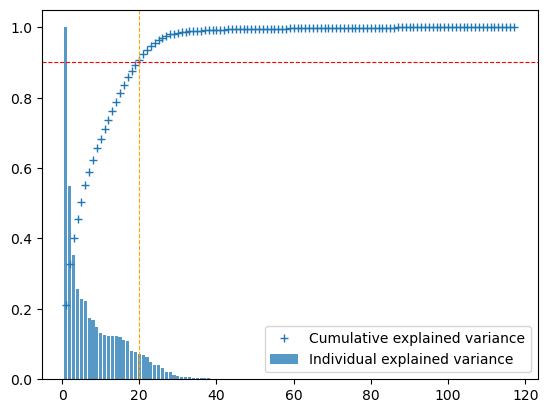

117

In [8]:
#https://scikit-learn.org/1.2/auto_examples/compose/plot_digits_pipe.html#sphx-glr-auto-examples-compose-plot-digits-pipe-py
pca_comp = pipe.named_steps['pca']

print("No. of components:", pca_comp.n_components_)
print("No. of numerical components:", len(numerical_features))
print("No. of categorical components:", len(pipe['transformer'].named_transformers_['categorical'].get_feature_names_out()))

plt.bar(np.arange(1,pca_comp.n_components_+1), pca_comp.explained_variance_/max(pca_comp.explained_variance_), alpha = 0.75, align='center',label='Individual explained variance')
plt.plot(np.arange(1,pca_comp.n_components_+1), pca_comp.explained_variance_ratio_.cumsum(),'+',label='Cumulative explained variance')
plt.axhline(0.90,linestyle='--',color='red',linewidth=0.8)
plt.axvline(20,linestyle='--',color='orange',linewidth=0.8)
plt.legend(loc='best')
plt.show()
len(pca_comp.get_covariance())

In [9]:
transformed = pipe['transformer']
print(transformed.get_feature_names_out())

['numerical__serrorrate' 'numerical__srvserrorrate'
 'numerical__rerrorrate' 'numerical__srvrerrorrate'
 'numerical__samesrvrate' 'numerical__diffsrvrate'
 'numerical__srvdiffhostrate' 'numerical__dsthostsamesrvrate'
 'numerical__dsthostdiffsrvrate' 'numerical__dsthostsamesrcportrate'
 'numerical__dsthostsrvdiffhostrate' 'numerical__dsthostserrorrate'
 'numerical__dsthostsrvserrorrate' 'numerical__dsthostrerrorrate'
 'numerical__dsthostsrvrerrorrate' 'numerical__duration'
 'numerical__srcbytes' 'numerical__dstbytes' 'numerical__land'
 'numerical__wrongfragment' 'numerical__urgent' 'numerical__hot'
 'numerical__numfailedlogins' 'numerical__loggedin'
 'numerical__numcompromised' 'numerical__rootshell'
 'numerical__suattempted' 'numerical__numroot'
 'numerical__numfilecreations' 'numerical__numshells'
 'numerical__numaccessfiles' 'numerical__numoutboundcmds'
 'numerical__ishostlogin' 'numerical__isguestlogin' 'numerical__count'
 'numerical__srvcount' 'numerical__dsthostcount'
 'numerical_

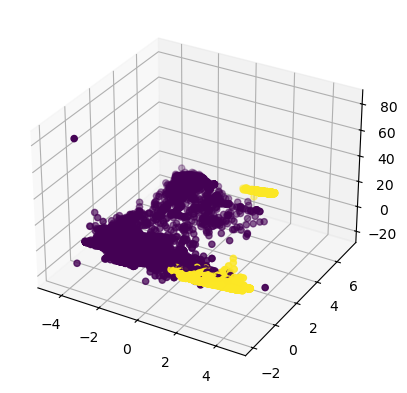

In [10]:
pca_output = pca_comp.transform(preProcessor.transform(df))

# widget requires ipympl
# %matplotlib widget
# from mpl_toolkits.mplot3d import Axes3D
figure = plt.figure()
ax = figure.add_subplot(111,projection='3d')
ax.scatter(pca_output[:,0],pca_output[:,1],pca_output[:,3],c=yTrain.iloc[:,0])
plt.show()

In [11]:
"""
    Let's try SVM
"""
clf1 = Pipeline(steps=[
    ('transformer',preProcessor),
    ('pca',PCA(n_components=2,random_state=RS)),
    ('svm',SVC(C=1.0,kernel='poly',degree=3,coef0=2.0))
])
clf1.fit(xTrain,yTrain.iloc[:,0]) # np.ravel can also be used

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['serrorrate', 'srvserrorrate', 'rerrorrate', 'srvrerrorrate',
       'samesrvrate', 'diffsrvrate', 'srvdiffhostrate', 'dsthostsamesrvrate',
       'dsthostdiffsrvrate', 'dsthostsamesrcportrate',
       'dsthostsrvdiffhostrate', 'dsthostserrorrate', 'dsth...
       'numfilecreations', 'numshells', 'numaccessfiles', 'numoutboundcmds',
       'ishostlogin', 'isguestlogin', 'count', 'srvcount', 'dsthostcount',
       'dsthostsrvcount', 'lastflag'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('1-hot '
                                                                   'encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['protocoltype', 'service', 'flag'], dtype='object'))])),
                ('pca', PCA(n_components=2, random_state=31)),
                ('svm', SVC(coef0=2.0, kernel='poly'))])

In [25]:
yPred = clf1.predict(xTarget)
# cross_validate(clf1,X=xTrain,y=np.ravel(yTrain),scoring='recall',cv=5)

In [28]:
result = pd.DataFrame({
    'attack': yPred
})
result.to_csv("submission.csv",index=False)